In [103]:
from pathlib import Path

import pandas as pd
from pyod.models.iforest import IForest

RANDOM_STATE = 42
INPUT_PATH = Path("./src/data/output/clean_ura_data.csv")

CAT_IMPUTER_STRATEGY = "constant"
CAT_CONSTANT = "missing"
NUM_IMPUTER_STRATEGY = "mean"

AD_DROP = [
    "IForest", 
    "IForest_label",
    "street", 
    "project", 
    "contract_date_dt", 
    "days_since_1st_trans",
    "floorRange", 
    "typeOfSale", 
    "district", 
    "typeOfArea",
    "marketSegment", 
    "age_bin",
    "latitude", 
    "longitude"
]
AD_CAT = ["marketSegment"]

DETECTORS = {"IForest": IForest(random_state=RANDOM_STATE)}

df_ura = pd.read_csv(INPUT_PATH)

In [121]:
import logging

import pandas as pd

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def diagnose_missing_data(
    df_ura, cat_imputer_strategy, num_imputer_strategy, cat_constant=None, num_constant=None
):
    """Tabulate missing values and log imputation strategies."""
    
    missing_counts = df_ura.isnull().sum()
    missing_percentages = 100 * missing_counts / len(df_ura)

    df_missing_summary = pd.DataFrame(
        {"Missing Count": missing_counts, "Missing Percentage": missing_percentages}
    ).sort_values(by="Missing Count", ascending=False)

    logger.info(f"Diagnosing Missing Values: \n {df_missing_summary}\n")
    if cat_imputer_strategy == "constant":
        logger.info(
            f"Missing categorical values will be imputed with the constant '{cat_constant}'."
        )
    else:
        logger.info(
            f"Missing categorical values will be imputed using '{cat_imputer_strategy}'."
        )

    if num_imputer_strategy == "constant":
        logger.info(
            f"Missing numerical values will be imputed with the constant '{num_constant}'.\n"
        )
    else:
        logger.info(
            f"Missing numerical values will be imputed using '{num_imputer_strategy}'.\n"
        )

In [140]:
import logging

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def process_data(
    df_ura,
    drop_features,
    cat_features,
    cat_imputer_strategy,
    num_imputer_strategy,
    cat_constant=None,
    num_constant=None,
):
    """
    Imputes missing values, encode categorical features, and scales numerical features. 
    Also returns a boolean array indicating which columns are categorical.
    """

    drop_cat_features = drop_features + cat_features
    num_features = list(df_ura.columns.difference(drop_cat_features))
    df_copy = df_ura[num_features + cat_features].copy()

    logger.info(f"Numerical features: {tuple(num_features)}")
    logger.info(f"Categorical features: {tuple(cat_features)} \n")

    diagnose_missing_data(
        df_copy, cat_imputer_strategy, num_imputer_strategy, cat_constant, num_constant
    )

    cat_imputer = SimpleImputer(
        strategy=cat_imputer_strategy,
        fill_value=cat_constant if cat_imputer_strategy == "constant" else None,
    )
    num_imputer = SimpleImputer(
        strategy=num_imputer_strategy,
        fill_value=num_constant if num_imputer_strategy == "constant" else None,
    )

    cat_transformer = Pipeline(
        steps=[
            ("imputer", cat_imputer),
            ("encoder", OneHotEncoder(sparse_output=False)),
        ]
    )
    num_transformer = Pipeline(
        steps=[("imputer", num_imputer), ("scaler", StandardScaler())]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer, num_features),
            ("cat", cat_transformer, cat_features),
        ]
    )

    pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

    x_processed = pipeline.fit_transform(df_copy)

    logger.info("Processing data for anomaly detection:")
    logger.info("Categorical features will be one hot encoded.")
    logger.info("Numerical features will be standardized using the StandardScaler.\n")

    feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
    is_cat = np.array(["cat__" in name for name in feature_names])

    return x_processed, is_cat

In [97]:
# Adapted : M. Beckmann  https://github.com/scikit-learn/scikit-learn/pull/9555

import numpy as np
from scipy.sparse import issparse
from sklearn.metrics import pairwise
from sklearn.utils import validation


def check_pairwise_arrays(X, Y, precomputed=False, dtype=None):
    X, Y, dtype_float = pairwise._return_float_dtype(X, Y)

    warn_on_dtype = dtype is not None
    estimator = "check_pairwise_arrays"

    if dtype is None:
        dtype = dtype_float

    if Y is X or Y is None:
        X = Y = validation.check_array(
            X,
            accept_sparse="csr",
            dtype=dtype,
            force_all_finite="allow-nan",
            estimator=estimator,
        )
    else:
        X = validation.check_array(
            X,
            accept_sparse="csr",
            dtype=dtype,
            force_all_finite="allow-nan",
            estimator=estimator,
        )
        Y = validation.check_array(
            Y,
            accept_sparse="csr",
            dtype=dtype,
            force_all_finite="allow-nan",
            estimator=estimator,
        )

    if precomputed:
        if X.shape[1] != Y.shape[0]:
            raise ValueError(
                "Precomputed metric requires shape "
                "(n_queries, n_indexed). Got (%d, %d) "
                "for %d indexed." % (X.shape[0], X.shape[1], Y.shape[0])
            )
    elif X.shape[1] != Y.shape[1]:
        raise ValueError(
            "Incompatible dimension for X and Y matrices: "
            "X.shape[1] == %d while Y.shape[1] == %d" % (X.shape[1], Y.shape[1])
        )

    return X, Y


def gower_distances(X, Y=None, feature_weight=None, cat_features=None):
    """Computes the gower distances between X and Y

    Gower is a similarity measure for categorical, boolean and numerical mixed
    data.


    Parameters
    ----------
    X : array-like, or pandas.DataFrame, shape (n_samples, n_features)

    Y : array-like, or pandas.DataFrame, shape (n_samples, n_features)

    feature_weight :  array-like, shape (n_features)
        According the Gower formula, feature_weight is an attribute weight.

    categorical_features: array-like, shape (n_features)
        Indicates with True/False whether a column is a categorical attribute.
        This is useful when categorical atributes are represented as integer
        values. Categorical ordinal attributes are treated as numeric, and must
        be marked as false.

        Alternatively, the categorical_features array can be represented only
        with the numerical indexes of the categorical attribtes.

    Returns
    -------
    similarities : ndarray, shape (n_samples, n_samples)

    Notes
    ------
    The non-numeric features, and numeric feature ranges are determined from X and not Y.
    No support for sparse matrices.
    """

    if issparse(X) or issparse(Y):
        raise TypeError("Sparse matrices are not supported for gower distance")

    y_none = Y is None

    # It is necessary to convert to ndarray in advance to define the dtype
    if not isinstance(X, np.ndarray):
        X = np.asarray(X)

    # this is necessary as strangelly the validator is rejecting
    # numeric arrays with NaN
    array_type = object

    if np.issubdtype(X.dtype, np.number) and (
        np.isfinite(X.sum()) or np.isfinite(X).all()
    ):
        array_type = type(np.zeros(1, X.dtype).flat[0])

    X, Y = check_pairwise_arrays(X, Y, precomputed=False, dtype=array_type)

    n_rows, n_cols = X.shape

    if cat_features is None:
        cat_features = np.zeros(n_cols, dtype=bool)
        for col in range(n_cols):
            # In numerical columns, None is converted to NaN,
            # and the type of NaN is recognized as a number subtype
            if not np.issubdtype(type(X[0, col]), np.number):
                cat_features[col] = True
    else:
        cat_features = np.array(cat_features)

    if np.issubdtype(cat_features.dtype, np.int64):
        new_cat_features = np.zeros(n_cols, dtype=bool)
        new_cat_features[cat_features] = True
        cat_features = new_cat_features

    # Categorical columns
    X_cat = X[:, cat_features]

    # Numerical columns
    X_num = X[:, np.logical_not(cat_features)].astype(np.float32)
    ranges_of_num = None
    max_of_num = None

    # Calculates the normalized ranges and max values of numeric values
    _, num_cols = X_num.shape
    ranges_of_num = np.zeros(num_cols)
    max_of_num = np.zeros(num_cols)
    for col in range(num_cols):
        col_array = X_num[:, col].astype(np.float32)
        max = np.nanmax(col_array)
        min = np.nanmin(col_array)

        if np.isnan(max):
            max = 0.0
        if np.isnan(min):
            min = 0.0
        max_of_num[col] = max
        ranges_of_num[col] = np.absolute(1 - min / max) if (max != 0) else 0.0

    # This is to normalize the numeric values between 0 and 1.
    X_num = np.divide(
        X_num, max_of_num, out=np.zeros_like(X_num), where=max_of_num != 0
    )

    if feature_weight is None:
        feature_weight = np.ones(n_cols)

    feature_weight_cat = feature_weight[cat_features]
    feature_weight_num = feature_weight[np.logical_not(cat_features)]

    y_n_rows, _ = Y.shape

    dm = np.zeros((n_rows, y_n_rows), dtype=np.float32)

    feature_weight_sum = feature_weight.sum()

    Y_cat = None
    Y_num = None

    if not y_none:
        Y_cat = Y[:, cat_features]
        Y_num = Y[:, np.logical_not(cat_features)].astype(np.float32)
        # This is to normalize the numeric values between 0 and 1.
        Y_num = np.divide(
            Y_num, max_of_num, out=np.zeros_like(Y_num), where=max_of_num != 0
        )
    else:
        Y_cat = X_cat
        Y_num = X_num

    for i in range(n_rows):
        j_start = i

        # for non square results
        if n_rows != y_n_rows:
            j_start = 0

        Y_cat[j_start:n_rows, :]
        Y_num[j_start:n_rows, :]
        result = _gower_distance_row(
            X_cat[i, :],
            X_num[i, :],
            Y_cat[j_start:n_rows, :],
            Y_num[j_start:n_rows, :],
            feature_weight_cat,
            feature_weight_num,
            feature_weight_sum,
            cat_features,
            ranges_of_num,
            max_of_num,
        )
        dm[i, j_start:] = result
        dm[i:, j_start] = result

    return dm


def _gower_distance_row(
    xi_cat,
    xi_num,
    xj_cat,
    xj_num,
    feature_weight_cat,
    feature_weight_num,
    feature_weight_sum,
    cat_features,
    ranges_of_num,
    max_of_num,
):
    # categorical columns
    sij_cat = np.where(xi_cat == xj_cat, np.zeros_like(xi_cat), np.ones_like(xi_cat))
    sum_cat = np.multiply(feature_weight_cat, sij_cat).sum(axis=1)

    # numerical columns
    abs_delta = np.absolute(xi_num - xj_num)
    sij_num = np.divide(
        abs_delta,
        ranges_of_num,
        out=np.zeros_like(abs_delta),
        where=ranges_of_num != 0,
    )

    sum_num = np.multiply(feature_weight_num, sij_num).sum(axis=1)
    sums = np.add(sum_cat, sum_num)
    sum_sij = np.divide(sums, feature_weight_sum)
    return sum_sij

In [141]:
import numpy as np
import pandas as pd
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.iforest import IForest

def detect_anomaly(df_ura, detectors):
    df_copy = df_ura.copy()
    n_detectors = len(detectors)

    x_processed, is_cat = process_data(
        df_ura, 
        drop_features=AD_DROP,
        cat_features=AD_CAT,
        cat_imputer_strategy=CAT_IMPUTER_STRATEGY,
        num_imputer_strategy=NUM_IMPUTER_STRATEGY,
        cat_constant=CAT_CONSTANT
    )

    outlier_scores = np.zeros([x_processed.shape[0], n_detectors])
    labels = np.zeros([x_processed.shape[0], n_detectors])

    logger.info("Running Isolation Forest:")
    for i, (detector_name, detector) in enumerate(detectors.items()):
        logger.info(f"{i}. {detector}")

        detector_name = detector
        detector_name.fit(x_processed)
        outlier_scores[:, i] = detector_name.decision_scores_
        labels[:, i] = detector_name.labels_

    outlier_scores_df = pd.DataFrame(
        np.round(outlier_scores, 3),
        columns=[f"{detector_name}" for detector_name in detectors.keys()],
    )
    labels_df = pd.DataFrame(
        labels.astype(int),
        columns=[f"{name}_label" for name in detectors.keys()]
    )

    df_copy = df_copy.join(outlier_scores_df)
    df_copy = df_copy.join(labels_df)

    return df_copy

df_ad_results = detect_anomaly(df_ura, detectors=DETECTORS)

INFO:__main__:Numerical features: ('area', 'noOfUnits', 'target_price')
INFO:__main__:Categorical features: ('marketSegment',) 

INFO:__main__:Diagnosing Missing Values: 
                Missing Count  Missing Percentage
area                       0                 0.0
noOfUnits                  0                 0.0
target_price               0                 0.0
marketSegment              0                 0.0

INFO:__main__:Missing categorical values will be imputed with the constant 'missing'.
INFO:__main__:Missing numerical values will be imputed using 'mean'.

INFO:__main__:Processing data for anomaly detection:
INFO:__main__:Categorical features will be one hot encoded.
INFO:__main__:Numerical features will be standardized using the StandardScaler.

INFO:__main__:Running Isolation Forest:
INFO:__main__:0. IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=42,
    verbose=0)


In [142]:
def sample_ad_data(
    df_ad, 
    score_col, 
    label_col, 
    top_n_outliers=100, 
    total_sample_size=500, 
    random_state=RANDOM_STATE
):
    df_outliers = (
        df_ad[df_ad[label_col] == 1].sort_values(by=score_col, ascending=False).head(top_n_outliers)
    )
    
    n_inliers = total_sample_size - len(df_outliers)
    df_inliers = df_ad[df_ad[label_col] == 0].sample(n=n_inliers, random_state=random_state)
    
    df_ad_sample = pd.concat([df_outliers, df_inliers]).reset_index(drop=True)
    
    return df_ad_sample

df_ad_sample = sample_ad_data(
    df_ad_results,
    score_col="IForest",
    label_col="IForest_label",
    top_n_outliers=10,
    total_sample_size=150
)

INFO:__main__:Numerical features: ('area', 'noOfUnits', 'target_price')
INFO:__main__:Categorical features: ('marketSegment',) 

INFO:__main__:Diagnosing Missing Values: 
                Missing Count  Missing Percentage
area                       0                 0.0
noOfUnits                  0                 0.0
target_price               0                 0.0
marketSegment              0                 0.0

INFO:__main__:Missing categorical values will be imputed with the constant 'missing'.
INFO:__main__:Missing numerical values will be imputed using 'mean'.

INFO:__main__:Processing data for anomaly detection:
INFO:__main__:Categorical features will be one hot encoded.
INFO:__main__:Numerical features will be standardized using the StandardScaler.



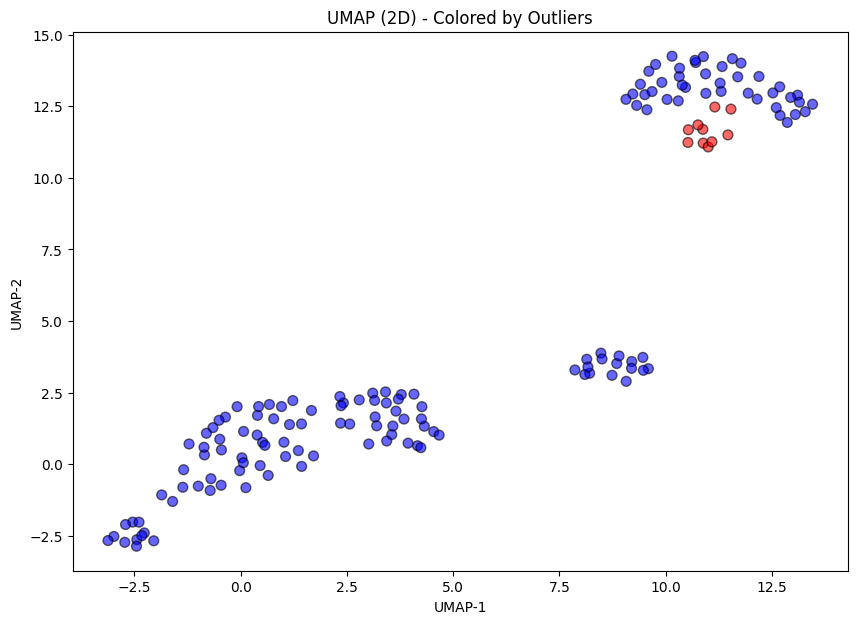

In [143]:
import warnings
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def plot_ad_umap(df_ad, label_col, gower=False):
    warnings.filterwarnings("ignore")

    x_processed, is_cat = process_data(
        df_ad, 
        drop_features=AD_DROP,
        cat_features=AD_CAT,
        cat_imputer_strategy=CAT_IMPUTER_STRATEGY,
        num_imputer_strategy=NUM_IMPUTER_STRATEGY,
        cat_constant=CAT_CONSTANT)

    if gower:
        x_processed = gower_distances(x_processed, cat_features=is_cat)
        metric = "precomputed"
    else:
        metric = "euclidean"
    
    reducer = umap.UMAP(
        n_components=2, 
        n_neighbors=50, 
        min_dist=0.5, 
        metric=metric, 
        random_state=RANDOM_STATE
    )
    embedding = reducer.fit_transform(x_processed)
    
    colors = ['blue' if label == 0 else 'red' for label in df_ad[label_col]]
    
    plt.figure(figsize=(10, 7))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, alpha=0.6, s=50, edgecolor='k')
    plt.title("UMAP (2D) - Colored by Outliers")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.show()

plot_ad_umap(df_ad_sample, label_col='IForest_label', gower=True)

In [144]:
display(df_ad_results.sort_values(by="IForest", ascending=False).head())

print(df_results["IForest_label"].sum()/len(df_results))

,target_price,area,floorRange,noOfUnits,typeOfSale,district,typeOfArea,street,project,marketSegment,contract_date_dt,days_since_1st_trans,age_bin,latitude,longitude,IForest,IForest_label
47299,392180000,13460.0,Floor 16-20,60,3,15,Strata,MEYER ROAD,MEYER PARK,RCR,2023-02-01,1006,Freehold,1.296257,103.891646,0.254,1
42958,371000000,14123.0,Floor 01-05,72,3,5,Strata,YEW SIANG ROAD,FLYNN PARK,RCR,2021-09-01,488,Freehold,1.278915,103.792744,0.254,1
43625,152000000,6084.0,Floor 11-15,40,3,15,Strata,TANJONG RHU ROAD,LA VILLE,RCR,2021-11-01,549,Freehold,1.299737,103.884418,0.251,1
21062,12200000,635.0,Floor 06-10,1,3,4,Strata,KEPPEL BAY VIEW,REFLECTIONS AT KEPPEL BAY,RCR,2022-08-01,822,"(0.803, 20.7]",1.267145,103.811002,0.248,1
22205,12500000,699.0,Floor 21-25,1,3,4,Strata,KEPPEL BAY VIEW,REFLECTIONS AT KEPPEL BAY,RCR,2022-10-01,883,"(0.803, 20.7]",1.267145,103.811002,0.248,1


0.1000077495350279


C:\Users\halfb\miniconda3\envs\milestone2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\halfb\miniconda3\envs\milestone2\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


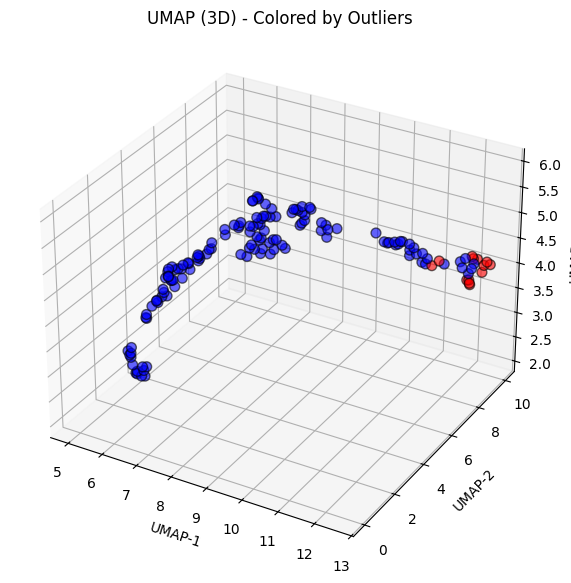

In [16]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler

X = df_sampled[AD_NUM].fillna(0) 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

reducer = umap.UMAP(n_components=3, random_state=RANDOM_STATE)
embedding = reducer.fit_transform(X_scaled)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Color points by IForest_label
colors = ['blue' if label == 0 else 'red' for label in df_sampled['Auto Encoder_label']]

ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2],
           c=colors, alpha=0.6, s=50, edgecolor='k')

ax.set_title("UMAP (3D) - Colored by Outliers")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
plt.show()


In [78]:
df_results.to_csv("./test.csv", index=False)

In [ ]:
import umap.plot

mapper = umap.UMAP().fit(df_sampled[AD_NUM])
umap.plot.points(mapper)

In [25]:
from sklearn.model_selection import train_test_split

sample_size = 500
frac = sample_size / len(df_results)

df_sampled, _ = train_test_split(
    df_results,
    train_size=frac,
    stratify=df_results['Auto Encoder_label'],
    random_state=RANDOM_STATE
)

print(df_sampled['Auto Encoder_label'].value_counts(normalize=True))
print(len(df_sampled))  # should be close to 5000


Auto Encoder_label
0    0.9
1    0.1
Name: proportion, dtype: float64
500
